# Complex Networks: the Erdös Number

Paul Erdös was a Hungarian mathematician. He lived from 1913 to 1996 and had 511 colaborators, while researchers usually have 3 or 4 collaborators in average. This impressive number is due to Erdös' peculiar lifestyle: he was always travelling, either to teach at a university, to attend to a seminar or to visit a colleague. He loved solving problems and his life was entirely devoted to mathematics, which enabled him to write more than 1500 articles.

As a tribute to him was created the Erdös number. It measures the distance from any researcher to Erdös. He himself has an Erdös number of 0, his direct co-authors have an Erdös number of 1, the co-authors' collaborators have an Erdös number of 2, and so on. This project aims at studying the graph of all people with an Erdös number of 2 or less. 

This graph comes from the *Erdös Number Project* [1], a website which contains collaboration data files and information about Erdös, the graph of his collaborators, the graph of all scientific collaborations, and comments about those last two. It also allows anyone to compute their Erdös number. Our data file comes from this website, and was updated in 2015. This project is not the first study of this graph: there are some facts disseminated on the website, but they are mostly about the whole collaboration graph or about a more restrictive definition of the Erdös number. Furthermore, an article was published by Vladimir Batagelj and Andrej Mrvar [9]. In this paper, they use the Erdös collaboration graph as an exemple of a large network on which they can present some graph analysis methods. Their goal was hence not to study the graph in itself, but to produce results which will benefit the graph theory community. Their version of this graph is from 1999 and counts 6100 vertices and 9939 edges. Today's graph has more than 11000 vertices and 18000, so our results will not be different than those in this paper. Furthermore, our goal is not the same: we intend to see what this graph teaches us about the collaboration habits of mathematicians. 

Indeed, we will ask the following questions: 
* Are there other authors with as many collaborators as Erdös?
* What does the degree distribution teach us about collaboration habits?
* Can we define a new number with the second mathematician having the highest number of collaborations?
* What does this graph look like if we take off Erdös' node?
* What centrality measure allows us to determine the most important authors of the network?
* Can we detect some relevant communities?


We will need some data about the authors of the graph: they either come from their wikipedia page [2], their personal page or their *ResearchGate* profile [3], from which we can for instance find an author's current number of co-authors. Since I looked for a lot of authors online, I will not provide the page reference for each.

## 1 - Construction of the graph

The Erdos_2.txt file was last updated in 2015. It lists the coauthors of Paul Erdös, together with their own coauthors listed beneath them. For each coauthor of Erdös the date of the first paper is given, but we will not use it. If the coauthor was known to be deceased in 2015, an asterisk follows their name. When two people have the same name, they are distinguished using carets.

The structure is the following : the coauthors of Erdös are listed in alphabetical order and are written in capital letters. Under each of them are listed their own collaborators, that is to say people with an Erdös number of 2. There is a tabulation before the name of those people. Here is an exemple : Ashbacher is a collaborator of Erdös, their first paper was published in 1997, and he had 7 co-authors other than Erdös.

***

ASHBACHER, CHARLES D. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;          1997

    Harmon, Gregory
    Le, Mao Hua
    Murthy, Amarnath
    Neirynck, Lori
    Nolte, William D., Jr.
    Straw, Mark
    Wilson, Lewis
    
***

Let us begin by importing all the libraries we will need for this study.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import statistics as st
from networkx.algorithms import community
from scipy.optimize import curve_fit

We start by extracting from our .txt file a list of nodes and edges. We start by reading every line and storing it as a string of characters in a list that we name `data_set`.

In [2]:
data_set = []
f = open('Erdos_2.txt')

for i in range (20699) :
    line = f.readline()
    data_set.append(line) # list of a list of strings

 The first step is to extract from a line in the file the name of the author. We can distinguish two types of strings: 
* the ones containing the name of a direct collaborator of Erdös, which are not tabulated but have a date at the end of the line separated from the author name by a lot of spaces. For instance, 
    'ABBOTT, HARVEY LESLIE &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1974'
* the ones containing the name of someone with an Erdös number of 2. They are tabulated. For instance,
    '&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Aull, Charles E.'

For each string, we have to get rid of all the spaces and of the date, if there is one. We also take off the stars indicating that the person is dead, and the symbol \n at the end of each line. This is what the function `extract_name` does. 

In [3]:
def extract_name (data, date = False) :
    
    line = data
    
    if date : # remove the date and all the spaces after the name
        line = line[0:-5] # take off the date
        car = line[-1]
        while not car.isalpha() and not car == '.' and not car.isdigit() and not car == ')':
            line = line[0:-1]
            car = line[-1]
            
    else : # remove all the spaces before the name
        car = line[0]
        while not car.isalpha() :
            line = line[1:]
            car = line[0]

        line = line.split('*')[0]
        line = line.split('\n')[0]
    return line

In order to test our function, we use a few examples: we check that the stars disappear like we wanted to, that all the letters are there and that the carets which allow us to distinguish two different people with the same name are still here. 

In [4]:
st1 = 'RENYI, ALFRED A.*                       1950'
st2 = '     RENYI, ALFRED A.*'

print(extract_name(st1, date=True))
print(extract_name(st2))
print(extract_name(st1, date=True)==extract_name(st2))

st3 = 'BEHZAD, MEHDI^1                         1991'
st4 = '    BEHZAD, MEHDI^1'

print(extract_name(st3, date=True))
print(extract_name(st4))
print(extract_name(st3, date=True)==extract_name(st4))

st5 = 'CHUNG, FAN RONG KING (GRAHAM)           1979'
st6 = '     CHUNG, FAN RONG KING (GRAHAM)'

print(extract_name(st5, date=True))
print(extract_name(st6))
print(extract_name(st5, date=True)==extract_name(st6))

RENYI, ALFRED A.
RENYI, ALFRED A.
True
BEHZAD, MEHDI^1
BEHZAD, MEHDI^1
True
CHUNG, FAN RONG KING (GRAHAM)
CHUNG, FAN RONG KING (GRAHAM)
True


We can now extract the names and create our graph. We use the Python package NetworkX to manipulate our graph. Our graph is called G. Since there are empty lines in the .txt file, for each element in our `data_set` list we have to check whether the string is of length 0.

We distinguish the collaborators of Erdös from the others thanks to the indentations: the collaborators of Erdös are indented, the others are not. Once we found a non indented author, we create a link between them and Erdös. Then, we know that they have collaborated with all the indented authors below them. The non-indented author is called *ref* (the reference), and for each non-indented author below this reference we create a link between them and the reference. Everytime we find a new non-indented author, the reference changes.

In [5]:
G = nx.Graph()
G.add_node('Erdos, Paul')

index = 0

for i in range (23, len(data_set)) : # values start at line 23 (there is some text above)
    data = data_set[i]
    test = data.split()
    
    if len(test) != 0 : # ignore the empty lines
        
        if data[0].isalpha() : # not indented : directly linked to Erdos
            name = extract_name(data, date = True)

            if not G.has_node(name) : # author not yet in the dictionary : add them, link them to Erdos
                G.add_node(name)
            
            ref = name # the next authors will be linked to this one
            G.add_edge('Erdos, Paul',ref)

        else :
            name = extract_name(data)

            if not G.has_node(name) : # author not yet in the dictionary : add them
                G.add_node(name)
        
            G.add_edge(name,ref) 

We export the edge list as a .txt file (which we then convert into a .csv file) in order to be able to represent our graph with Gephi. Since there are already commas in our file, we use a semicolon as a delimiter.

In [6]:
nx.write_edgelist(G, "Edgelist_for_gephi", delimiter=';', data=False) # to be used with gephi

We can take a look at the result by creating the table of all the edges thanks to the Pandas package of Python. This package names our nodes **source** and **target** even though the graph is not oriented. 

In [7]:
panda_table = nx.to_pandas_edgelist(G)
panda_table.head(10)

,source,target
0,"Erdos, Paul","ABBOTT, HARVEY LESLIE"
1,"Erdos, Paul","ACZEL, JANOS D."
2,"Erdos, Paul","AGOH, TAKASHI"
3,"Erdos, Paul","AHARONI, RON"
4,"Erdos, Paul","AIGNER, MARTIN S."
5,"Erdos, Paul","AJTAI, MIKLOS"
6,"Erdos, Paul","ALAOGLU, LEONIDAS"
7,"Erdos, Paul","ALAVI, YOUSEF"
8,"Erdos, Paul","ALLADI, KRISHNASWAMI"
9,"Erdos, Paul","ALON, NOGA M."


Finally, let us look at the graph with Gephi. The node sizes are proportional to the node degrees, and the colours correspond to communities computed by Gephi. Those communities will be described in more details below. This network was visualized using the ForceAtlas spatialisation, which interpretes each node as a particle repelled by the others while links add a return force. We only display the names of the nodes with a degree higher than 150.

<img src="Community.png">

## 2 - The degree distribution

Now that we constructed our graph, we can study it. Let us start by the most basic properties, that is to say the number of nodes and edges. We count $|V| = 11526$ vertices and $|E| = 18506$ edges. This allows us to compute the density using the following formula:

$$\text{density} = \frac{2|E|}{|V|(|V|-1)}$$

We get a density of 0.00028, which shows that our graph is really sparse, which is not surprising for a collaboration network. Then we compute the diameter of the graph, which is the maximum shortest path between two nodes, and we get 4. Indeed, a path cannot be of length higher than 4: one node is either connected to Erdös or to one of his collaborator. Let us take two authors who never collaborated with Erdös, Author1 and Author2. Author1 is linked to Collaborator1 who collaborated with Erdös, and Author2 is linked to Colaborator2. Hence the maximum shortest path between two authors:

**Author1 - Collaborator1 - Erdös - Collaborator2 - Author2**

which has a length of 4.

In [8]:
E = G.number_of_edges()
N = G.number_of_nodes()
den = nx.density(G)
# dia = nx.diameter(G) # is 4 (very long to compute)
print( 'Number of nodes: ', N)
print('Number of edges: ', E)
print('Density of the graph: ', den)
# print('Diameter of the graph: ', dia)

Number of nodes:  11526
Number of edges:  18506
Density of the graph:  0.0002786268750872779


We want to extract some properties about the degree of the vertices in our graph: the maximum value, the minimum value, the mean, the standard deviation... And we want to be able to compare people with different Erdös numbers. In order to do so, we create lists of authors of Erdös number 0, 1 and 2 with their number of collaborators (the degree of their node). Of course, only Erdös has an Erdös number of 0. 

In [9]:
List_en1 = []
List_en2 = []
List_en0 = ['Erdos, Paul']

for n in nx.nodes(G) :

    if n in nx.all_neighbors(G, 'Erdos, Paul') :
        List_en1.append(n)
    else : 
        if n != 'Erdos, Paul' :
            List_en2.append(n)

From those lists we compute all the parameters we wanted. We denote by **all** the population of the whole graph and by **en1** (respectively **en2**) the population of authors with an Erdös number of 1 (respectively 2).

In [10]:
degree_sequence_all = sorted([[G.degree(node), node] for node in List_en1+List_en2+List_en0], reverse=True)
degree_sequence_en1 = sorted([[G.degree(node), node] for node in List_en1], reverse=True)
degree_sequence_en2 = sorted([[G.degree(node), node] for node in List_en2], reverse=True)

list_degrees_all = [deg[0] for deg in degree_sequence_all]
list_degrees_en1 = [deg[0] for deg in degree_sequence_en1]
list_degrees_en2 = [deg[0] for deg in degree_sequence_en2]

data_degree = {'All':[max(degree_sequence_all)[0], max(degree_sequence_all)[1], min(degree_sequence_all)[0], min(degree_sequence_all)[1], st.mean(list_degrees_all), st.stdev(list_degrees_all)], 'Erdös number of 1':[max(degree_sequence_en1)[0], max(degree_sequence_en1)[1], min(degree_sequence_en1)[0], min(degree_sequence_en1)[1], st.mean(list_degrees_en1), st.stdev(list_degrees_en1)], 'Erdös number of 2':[max(degree_sequence_en2)[0], max(degree_sequence_en2)[1], min(degree_sequence_en2)[0], min(degree_sequence_en2)[1], st.mean(list_degrees_en2), st.stdev(list_degrees_en2)]} 

Degree_panda = pd.DataFrame(data_degree, index = ['Maximum degree', 'Author with maximum degree', 'Minimum degree', 'Author with minimum degree', 'Mean degree', 'Standard deviation'])
Degree_panda

,All,Erdös number of 1,Erdös number of 2
Maximum degree,511,436,19
Author with maximum degree,"Erdos, Paul","ALON, NOGA M.","Lesniak, Linda M."
Minimum degree,1,1,1
Author with minimum degree,"ANNING, NORMAN H.","ANNING, NORMAN H.","Aagedal, Jan Oyvind"
Mean degree,3.21117,39.4677,1.48293
Standard deviation,13.3281,45.7465,1.26065


Not surprisingly, in the whole graph the maximum degree is the one of Erdös' node. If we only consider the authors of Erdös number 1, that is to say the direct colaborators of Erdös, the maximum degree is 436: that is approximately 80 collaborators less than Erdös, but it is a big number compared to the mean value which is around 40. 

We must keep in mind that the people with Erdös number 2 have one of their collaborators in this graph only if this collaborator has worked either with Erdös himself or with one of Erdös' direct collaborators. Hence, it is probable that most of them have more collaborators than what is shown by our graph: we compute (see below) that 77 % of them have a degree of 1, and the maximum degree is 19. The author who has this degree 19 is Linda Lesniak, and she actually has 50 co-authors in total if we look at her *ResearchGate* profile. 

When it comes to the authors with an Erdös number of 1 the mean degree is 39.4, meaning that those authors have in average 40 collaborators. This value is actually quite large: the Erdos project page teaches us that if we look at the graph of all collaborations in mathematics the average number of collaborators is of 3.36 (there are 676000 authors in this graph). One explanation could be that the people who collaborated with Erdös were those used to collaborating with a lot of other researchers, while most authors had just around 4 co-authors. 

Finally, the standard deviation is interesting. It is very low for the authors with an Erdös number of 2, which makes sense since most of them has only 1 collaborator in the graph. On the contrary, it is quite high for the people with a number of 1: 46 of deviation for an average of 40. The reason for that is that the degree distribution (shown below) is very noisy, with most authors having a degree between 1 and 100. 

Let us now look at the 10 authors with the most collaborators.

In [11]:
data_rank = {'Name': [degree_sequence_all[i][1] for i in range (11)], 'Number of collaborations': [degree_sequence_all[i][0] for i in range (11)], 'Domains of activity': ['Discrete mathematics, graph theory, number theory, mathematical analysis, approximation theory, set theory, and probability theory', ' Combinatorics, theoretical computer science', 'Graph theory', 'Graph thoery, geometry', 'Graph theory', ' Mathematical logic, model theory, axiomatic set theory', 'Biomathematics, thermodynamics, geometrical thermodynamics, optimization and mathematical modeling', 'Graph theory, discrete mathematics', ' Scheduling theory, computational geometry, Ramsey theory, quasi-randomness', 'Number thoery', 'Data science, macro-informatics, cognitive computing, interconnection networks']}

Rank_panda = pd.DataFrame(data_rank)
pd.options.display.max_colwidth = 500
Rank_panda.head(11)

,Name,Number of collaborations,Domains of activity
0,"Erdos, Paul",511,"Discrete mathematics, graph theory, number theory, mathematical analysis, approximation theory, set theory, and probability theory"
1,"ALON, NOGA M.",436,"Combinatorics, theoretical computer science"
2,"HARARY, FRANK",316,Graph theory
3,"COLBOURN, CHARLES JOSEPH",245,"Graph thoery, geometry"
4,"TUZA, ZSOLT",225,Graph theory
5,"SHELAH, SAHARON",224,"Mathematical logic, model theory, axiomatic set theory"
6,"SALAMON, PETER",221,"Biomathematics, thermodynamics, geometrical thermodynamics, optimization and mathematical modeling"
7,"WEST, DOUGLAS BRENT",202,"Graph theory, discrete mathematics"
8,"GRAHAM, RONALD LEWIS",197,"Scheduling theory, computational geometry, Ramsey theory, quasi-randomness"
9,"LUCA, FLORIAN",194,Number thoery


The rate at which the number of collaborators decreases is stunning: from Erdös to Alon, from Alon to Harary, from Harary to Colbourn, the number of co-authors goes down by almost 100 every time. From this table we can also see the domains of research of those people. Not surprinsingly, all those domains are close to the ones that Erdös studied since they all published at least one paper with him. We can see that a lot of them worked in graph theory.

We can finally plot the degree distributions for our three categories (all authors, Erdös number of 1, Erdös number of 2).

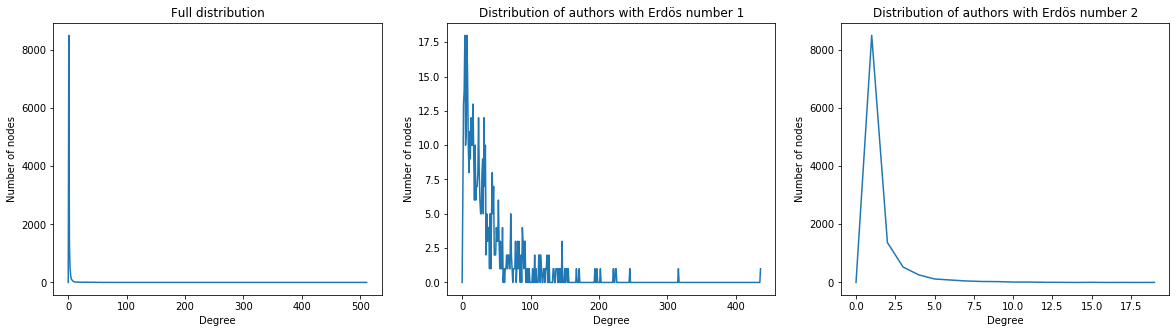

In [12]:
degree_distribution_all = [0]*(max(degree_sequence_all)[0]+1) # degree distribution
for deg in degree_sequence_all :
    index = deg[0]
    degree_distribution_all[index] += 1
    
degree_distribution_en1 = [0]*(max(degree_sequence_en1)[0]+1) # degree distribution
for deg in degree_sequence_en1 :
    index = deg[0]
    degree_distribution_en1[index] += 1

degree_distribution_en2 = [0]*(max(degree_sequence_en2)[0]+1) # degree distribution
for deg in degree_sequence_en2 :
    index = deg[0]
    degree_distribution_en2[index] += 1

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(degree_distribution_all)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
# plt.ylim([0,20]) # for a zoom
plt.title('Full distribution')

plt.subplot(132)
plt.plot(degree_distribution_en1)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Distribution of authors with Erdös number 1')

plt.subplot(133)
plt.plot(degree_distribution_en2)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Distribution of authors with Erdös number 2')

plt.show()

The full distribution is difficult to read: there are so many nodes with a very small degree that we only see a high peak. The distributions of the authors with an Erdös number of 1 and 2 are clearer. The distribution of authors with an Erdös number of 2 is quite noisy, which may be because there are less data (511 nodes compared to more than 10000 in the other two distributions). For all three distributions we can see that there are a lot of nodes with only a few links, and some hubs with very high degrees, but this information is only trustworthy in the case of the researchers with an Erdös number of 1 since the others do not have all their collaborators in the graph.

From those distributions we can confirm what we saw with the degree statistics. Most authors have between 1 and 5 co-authors, which is consistent with the average of 3.36 in the whole graph of mathematician collaborators. The people with an Erdös number of 1 tend to have a lot of collaborators besides Erdös, which give a distribution less peaked than the one for all authors, and hence much more noisy. Finally, since not all of their collaborators are taken into account, the majority of the authors with an Erdös number of 2 only have 1 collaborator (77 % of them).

In [13]:
Nb_authors = G.number_of_nodes()
print(int(degree_distribution_all[1]/Nb_authors*100), '% of the authors have only one collaborator')
print(int(sum(degree_distribution_all[1:6])/Nb_authors*100), '% of the authors have between 1 and 5 collaborators')

Nb_authors_en2 = len(List_en2)
print(int(degree_distribution_all[1]/Nb_authors_en2*100), '% of the authors with an Erdös number of 2 have only one collaborator')

Nb_authors_en1 = len(List_en1)
print(int(degree_distribution_en1[1]/Nb_authors_en1*100), '% of the authors with an Erdös number of 1 have only one collaborator')

73 % of the authors have only one collaborator
94 % of the authors have between 1 and 5 collaborators
77 % of the authors with an Erdös number of 2 have only one collaborator
1 % of the authors with an Erdös number of 1 have only one collaborator


Furthermore, those distributions look like power laws. Let us draw them again but with logarithmic scales. We modelize the distribution by a power law  fitted manually (the fitting method from scipy does not work on our data).

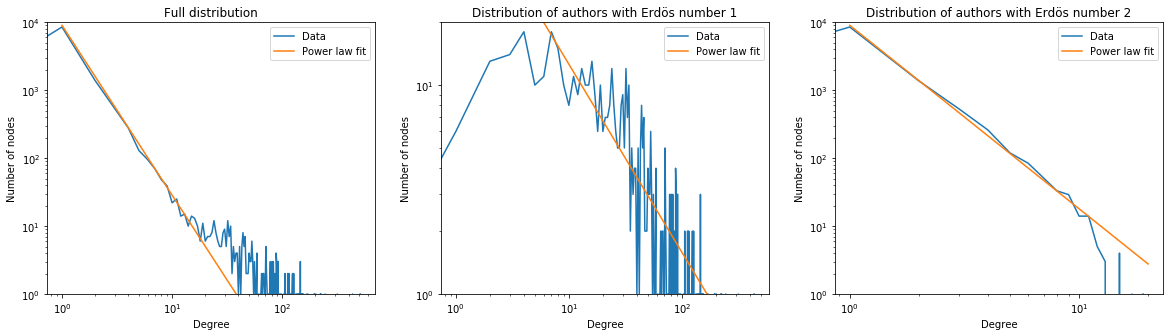

In [14]:
def fct_fit(x,a,b) :
    return a/x**b

N_all = [i for i in range (1,len(degree_distribution_all)+1)]
#popt, pcov = curve_fit(fct_fit, N_all, degree_distribution_all)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(degree_distribution_all, label='Data')
plt.plot(N_all, [9000/nall**2.5 for nall in N_all], label='Power law fit') # fct_fit(N_all, *popt)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.xscale('log')
plt.yscale('log')
# plt.ylim([0,20]) # for a zoom
plt.title('Full distribution')
plt.ylim([1, 10000])
plt.legend()

N_en1 = [i for i in range (1,len(degree_distribution_en1)+1)]
plt.subplot(132)
plt.plot(degree_distribution_en1, label='Data')
plt.plot(N_en1, [100/nen1**0.9 for nen1 in N_en1], label='Power law fit') # fct_fit(N_all, *popt)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of authors with Erdös number 1')
plt.ylim([1, 20])
plt.legend()

N_en2 = [i for i in range (1,len(degree_distribution_en2)+1)]
plt.subplot(133)
plt.plot(degree_distribution_en2, label='Data')
plt.plot(N_en2, [9000/nen2**2.7 for nen2 in N_en2], label='Power law fit') # fct_fit(N_all, *popt)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of authors with Erdös number 2')
plt.ylim([1, 10000])

plt.legend()
plt.show()

On the full distribution the power law seems to fit quite well the data (coefficient 2.5), the same goes for the ditribution of people with an Erdös number of 2 (coefficient 2.7). Unfortuntely, the only distribution which is really meaningfull since it contains all the authors' collaborators is too noisy to conclude anything. The power law seems to fit (coefficient 0.9), but the noise is too important for us to be really accurate.

## 3 - A graph without Erdös

Bey definition, Erdös connects all the nodes together. What happens if we delete his node? Let's find out! We define G2, the graph containing all the nodes but Erdös'. We start by comparing the simplest features: the number of nodes, of edges, the density, the diameter...

In [15]:
G2 = G.copy()
G2.remove_node('Erdos, Paul')

E2 = G2.number_of_edges()
N2 = G2.number_of_nodes()
den2 = nx.density(G)
# dia2 = nx.diameter(CC[0]) # 12 (very long to compute)

print('Loss of', E-E2, ' edges')
data_G2 = {'Number of nodes': [N, N2], 'Number of edges': [E, E2], 'Density': [den, den2], 'Connected?': [nx.is_connected(G), nx.is_connected(G2)], 'Diameter of largest CC': [4,12]}

G2_panda = pd.DataFrame(data_G2, index=['With Erdös', 'Without Erdös'])
G2_panda

Loss of 511  edges


,Number of nodes,Number of edges,Density,Connected?,Diameter of largest CC
With Erdös,11526,18506,0.000279,True,4
Without Erdös,11525,17995,0.000279,False,12


For now the results are obvious: by deleting Erdös we took off one node and 511 edges, and this does not affect the density a lot. A more interesting result is the fact that the graph is not connected anymore. Let us look at the connected components.

In [16]:
CC_size = [len(c) for c in sorted(nx.connected_components(G2), key=len, reverse=True)]
print('G2 has ', len(CC_size), ' connected components')

print('Size of the different connected components: ', CC_size)

CC = [G2.subgraph(c) for c in nx.connected_components(G2)]

G2 has  14  connected components
Size of the different connected components:  [11480, 13, 8, 5, 4, 3, 3, 3, 1, 1, 1, 1, 1, 1]


In [17]:
len(CC[0])
BB_graph = nx.union(CC[1], CC[2])
for i in range (3, 14) :
    BB_graph = nx.union(BB_graph, CC[i])
nx.write_edgelist(BB_graph, "Edgelist_no_Erdos", delimiter=';', data=False) # to be used with gephi

There are 14 different connected components: the largest contains most of the nodes. The second largest connected component has 13 nodes, and there are in total only 45 nodes outside of the largest connected component: even if we take Erdös off, the graph is still almost connected. 

We export to Gephi the edgelists of all the connected components but the largest. We can see what those connected components look like.

<img src="BB_graph.png", width="600">

There are a few nodes without any links: those are the researchers who only collaborated with Erdös and no one else.

The other components are, except for one, composed of one co-author of Erdös and their own co-authors. Those co-authors are linked to no other researchers of the graph, which explains why their component was disconnected when we took Erdös off.

The second largest component is mostly made of Israeli mathematicians. Abraham Ginzburg and Abraham Ziv wrote with Erdös the Erdös-Ginzburg-Ziv theorem (number theory), which is why they are linked together. Since neither them or their own co-authors collaborated with other individuals in the general graph, they were disconnected too when Erdös' node was deleted.

The small number of nodes which were disconnected when the graph lost its most important node could indicates that there is a high clustering in this graph. Let us look at the average clustering coefficient. The clustering coefficient of a node u was defined by Luce and Perry in 1949 [8], it is the fraction of possible triangles through that node that exist

$$C_u = \frac{2T(u)}{deg(u)(deg(u)−1)}$$

where T(u) is the number of triangles and deg(u) the degree of the node u. The average clustering coefficient is simply defined by:

$$ C = \frac{1}{N} \sum_{v \in G} C_v$$

In [18]:
print('Average clustering coefficient of G: ', nx.average_clustering(G)) 

Average clustering coefficient of G:  0.10583676717061977


This high clustering coefficient and the small distances in the graph (diameter of 4) indicate that we are in the presence of a small-world graph. Indeed, mathematicians tend to collaborate more with the people they meet in their research teams or at seminars. Erdös' behavior is very uncommon, most people do not travel randomly to collaborate with any colleague they meet. This explains why our graph has clusters: usually collaborations happen inside a same lab or at least in the same country.

## 4 - Centrality measures

Until this section we only looked at the degree to determine which nodes are the most important in the network. Let us compute some other centralities and see if some other authors emerge. The NetworkX library has functions which can compute some centralities, but they are extremely slow because of the size of our network. Instead of using those, we used Gephi's algorithms. 

We will look at two centralities. The first one is the betweenness centrality: it is the number of shortest paths which go through each node. Let $\sigma_{st}$ be the number of shortest paths from node $s$ to node $t$ and $\sigma_{st}(v)$ the number of shortest paths going through node $v$. The betweenness centrality of a node $v$, as it was defined by Anthonisse in 1971 [4], is given by:

$$ C_B(v) = \sum_{s \neq v \neq  t \in V} \frac{\sigma_{st}(v)}{\sigma_{st}} $$

Then we will look at the closeness centrality, which shows how close a node is to the others. It was define by Sabidussi in 1966 [5]. Let us denote $d_G(s,t)$ the minimum length of any path connecting node $s$ and node $t$ in the graph G, the closeness of a node is:

$$ C_C(v) = \frac{1}{\sum_{t \in V}d_G(v,t)} $$

The algorithm used by Gephi is the one designed by Ulrik Brandes [6]. In the table below are, computed by Gephi, the centralities for each node.

Finally, we also looked at the community structure of our graph. Each node has been associted by the Gephi algorithm to a modularity class, which uses the method proposed by Blondel et al. in [7]. This yields 11 communities, we will study them in more details below. Each community is associated to a *modularity class* value between 0 and 10.

In [19]:
data_centralities_raw = pd.read_csv("Centralities.csv") 
data_centralities = data_centralities_raw.sort_values(by='Degree', ascending=False)

data_centralities.head(15)

,Node ID,Degree,Modularity class,Betweenness centrality,Closeness centrality
0,"Erdos, Paul",511,10,0.754279,0.511329
10,"ALON, NOGA M.",438,10,0.053781,0.379180
187,"HARARY, FRANK",318,10,0.038197,0.363155
86,"COLBOURN, CHARLES JOSEPH",245,10,0.029156,0.352898
479,"TUZA, ZSOLT",226,10,0.026389,0.365353
421,"SHELAH, SAHARON",224,5,0.027771,0.347213
395,"SALAMON, PETER",221,6,0.037471,0.342765
498,"WEST, DOUGLAS BRENT",202,10,0.021248,0.357559
165,"GRAHAM, RONALD LEWIS",199,10,0.022237,0.369485
289,"LUCA, FLORIAN",194,3,0.023089,0.344867


Let us first study the betweenness centrality. We have normalized it, so the values range from 0 to 1. Here are the authors ranked by their betweenness centrality (we only displayed the 10 firsts):

In [20]:
B_panda = data_centralities_raw[['Node ID', 'Betweenness centrality']]
B_panda = B_panda.sort_values(by=['Betweenness centrality'], ascending=False)
B_panda.head(11)

,Node ID,Betweenness centrality
0,"Erdos, Paul",0.754279
10,"ALON, NOGA M.",0.053781
187,"HARARY, FRANK",0.038197
395,"SALAMON, PETER",0.037471
86,"COLBOURN, CHARLES JOSEPH",0.029156
421,"SHELAH, SAHARON",0.027771
479,"TUZA, ZSOLT",0.026389
219,"HSU, DERBIAU FRANK",0.026378
289,"LUCA, FLORIAN",0.023089
165,"GRAHAM, RONALD LEWIS",0.022237


We can first notice that this ranking is not the same as the ranking according to the degree. The first three do not change. Most authors in this ranking by the betweenness were already in the ranking by the degree exept for WEST, DOUGLAS BRENT who is not among the first 11 anymore and KOREN, ISRAEL who appeared in the ranking. The other authors of the ranking have either lost or gained places. This gives us a new evaluation of the important nodes, very consistent with the evaluation by the degree. 

While the difference between Alon Noga and Erdös' degrees was not very high, here Erdös' betweenness is one order of magnitude above everyone else's, at 0.75 while Alon Noga has 0.05. Indeed, a lot of shortest paths going from one author to another go through Erdös' node: by definition, the other nodes are either linked to Erdös or to one of his neighbours. It is hence not a surprise that his betweenness is extremely high. 

We can explain why the ranking does not change a lot: the nodes with high degrees are all direct collaborators of Erdös. Since they have very high degrees, they have a lot of neighbours. Those neighbours, when looking for a shortest path to another node, will most probably have to go through Erdös since he connects very different parts of the graph, and the fastest way to reach Erdös is to go through their neighbour with a very high degree. Consequently, there are a lot of shortest paths which will go through the nodes with high degrees. Of course some shortest paths will not go through Erdös, but a majority of them will, so the degree is highly linked to the betweenness. 

Here is an image of the graph with the nodes size and color representing their betweenness. We only displayed the labels of the 20 nodes with the highest betweenness. 


<img src="Betweenness.png", width="1000">

Now let us do the same thing for the closeness:

In [21]:
C_panda = data_centralities_raw[['Node ID', 'Closeness centrality']]
C_panda = C_panda.sort_values(by=['Closeness centrality'], ascending=False)
C_panda.head(11)

,Node ID,Closeness centrality
0,"Erdos, Paul",0.511329
10,"ALON, NOGA M.",0.379180
165,"GRAHAM, RONALD LEWIS",0.369485
378,"RODL, VOJTECH",0.367238
44,"BOLLOBAS, BELA",0.366409
479,"TUZA, ZSOLT",0.365353
440,"SPENCER, JOEL HAROLD",0.364498
78,"CHUNG, FAN RONG KING (GRAHAM",0.364176
148,"FUREDI, ZOLTAN",0.363912
326,"NESETRIL, JAROSLAV",0.363808


Here the ranking changes more: 6 mathematicians out of 11 were not in the previous rankings. Erdös and Alon are still the two firsts, but no other authors kept their original ranking. For instance even though HARARY, FRANK has a degree of 
318 and GRAHAM, RONALD LEWIS only has 199, Graham is more central than Harary with a closeness centrality of 0.369 for Graham and of 0.363 for Harary. We can remark that the values are quite close though.

Once again, since the closeness measures how close one node is from all the others, it is very high for Erdös. He was indeed placed at the center of the network by definition. But contrarely to the betweenness centrality, here the values are less widely spread than for the betweenness centrality: Erdös has approximately 0.5, his collaborators have between 0.3 and 0.4, and the collaborators of his collaborators have around 0.2. 

Here is an image of the graph with the nodes size and color representing their closeness. We only displayed the labels of the 20 nodes with the highest closeness. The color scale is the same as the previous graph: the predominance of Erdös is less obvious here, even though is is still clear that his node is the biggest. The closeness of the other nodes is not very far from his. 

<img src="Closeness.png", width="1000">

To conclude on the centralities, it appears that the importance of the different nodes was made quite clear by measuring their degrees. The geometric centrality measures that we studied showed us other authors who are important in the network even though their degree is not so high, either because they have a high betweenness or a high closeness. Finally, there is a correlation between the degree and the two centrality measures: the nodes with a high centrality have a high degree and are direct collaborators of Erdös. One last thing that could be helpful is to look at the communities. They are shown on this graph:

<img src="Community.png", width="1000">

The algorithm detected 11 communities. Some are quite small, with only a dozen of nodes, but others are way larger with thousands of nodes. We would like to see if this partition corresponds to parameters such as the domain of activity of the author or the country they work in.
To do so, we look at the 5 authors with the highest degree in each community. It would be more accurate to look at more authors in each community, but it would take too much time. We consider that the authors with the highest degrees are the centers of their communities and are enough to be able to describe those communities. This is probably more true in the smallest communities, and probably wrong in the biggests. 

In [22]:
Com = [0,1,2,3,4,5,6,7,8,9,10]
Size = [0.1, 0.1, 2.4, 13.5, 3.7, 7.7, 1.9, 0.2, 8.4, 4.4, 57.6]
Max_d = [8, 11, 171, 194, 133, 224, 221, 16, 96, 140, 511]
Act = ['number theory', 'algebra, logic, statistics, number theory, computer science', 'data science, computer science, number theory, discrete mathematics, automorphic functions', 'number theory and computer science', 'cryptography, information theory, computer science, networks', 'logic, set theory, applied mathematics, geometry, computer science', 'biomathematics, geometrical thermodynamics, physics, computer science', 'computer science, algebra, number theory, group theory', 'computer science, analysis, logic, partial differential equations', 'algebra, information theory, computer science, graph theory, random walk', 'discrete mathematics, graph theory, combinatorics, computer science, geometry']
Work = ['US and other', 'Israel (4), Germany', 'US', 'US, Germany, UK, Poland', 'Israel (4) and US (1)', 'Israel, US, UK', 'US, UK, Israel', 'US', 'US', 'US, Germany, Russia, Hungary', 'US (3), Canada, Hungary']


data_communities = {'Community': Com, 'Size (%)': Size, 'Maximum degree': Max_d, 'Domains of activity': Act, 'Work country': Work}
communities_panda = pd.DataFrame(data_communities)
pd.options.display.max_colwidth = 500
communities_panda = communities_panda.sort_values(by=['Size (%)'], ascending=False)
communities_panda = communities_panda.style.hide_index()
communities_panda

Community,Size (%),Maximum degree,Domains of activity,Work country
10,57.6,511,"discrete mathematics, graph theory, combinatorics, computer science, geometry","US (3), Canada, Hungary"
3,13.5,194,number theory and computer science,"US, Germany, UK, Poland"
8,8.4,96,"computer science, analysis, logic, partial differential equations",US
5,7.7,224,"logic, set theory, applied mathematics, geometry, computer science","Israel, US, UK"
9,4.4,140,"algebra, information theory, computer science, graph theory, random walk","US, Germany, Russia, Hungary"
4,3.7,133,"cryptography, information theory, computer science, networks",Israel (4) and US (1)
2,2.4,171,"data science, computer science, number theory, discrete mathematics, automorphic functions",US
6,1.9,221,"biomathematics, geometrical thermodynamics, physics, computer science","US, UK, Israel"
7,0.2,16,"computer science, algebra, number theory, group theory",US
0,0.1,8,number theory,US and other


The table above shows for each community the portion of nodes from the network it contains, the maximum degree, the domains of activity of the 5 researchers with the highest degree and the country in which they work. 

The community 0 is composed of ASHBACHER, CHARLES D. and his co-authors (without Erdös), and the community 1 is made of ZIV, ABRAHAM and GISBURG, ABRAHAM and their collaborators. Those two groups were two of the connected components which appeared when we took Erdös' node off, so we get why they are considered as two distinct communities: they are weakly connected to the rest of the network, and well connected inside the community. 
The other communities do not correspond to the connected components we studied in the last section, they are larger. There is one community, number 10, which is composed of more than half of the network, it is Erdös' community. The others are smaller. 

For the smallest communities we can see that the localisation of the authors plays a role. Indeed, the community 1 is mainly based is Israel, the community 0 and 7 in the US (we couldn't find the localisation of all the authors). Since those are small communities with 0.1% or 0.2% of the network nodes we can assume that those are indeed communities mostly based in one country. The fields of research vary a lot: we cannot say that the communities are based on the it. Inside one community there can be a lot of different domains. The only exception is community 0 which only studies number theory.

For bigger communities we can also see sometimes one dominant country: the US for communities 8 and 2 and Israel for community 4. But since there are way more than 5 authors inside those communities it may not be relevant to consider that they are all mainly based in one country. 

On a closing note, we can say that the smallest communities are based on the authors' location, but not really on their research field. The other communities are too big to say anything on the location. If we wanted more relevant communities we should make smaller groups, which is possible thanks to the Gephi algorithm. But it would be impossible to analyse them the way we did here because there would be too many.

## 5 - From the Erdös Number to the Alon Number

What is the average Erdös number for a researcher today? Let us look at the mathematicians from the geometry team of the ENS of Lyon. We use the *MathSciNet* distance calculator [10]. We did not display the researchers who were not on the data base of the distance calculator (because they did not write any papers): 4 members are not shown.

In [23]:
data_geometry = {'Name': ['Aurélien Alvarez', 'Claude Danthony', 'Mikael De la Salle', 'Damien Gaboriau', 'Etienne Ghys', 'Alexey Glutsyuk', 'Adrien Le Boudec', 'Amine Marrakchi', 'Marco Mazzucchelli', 'Bruno Sevennec', 'Jean-Claude Sikorav', 'Alexei Tsugvintsev', 'Abdelghani Zeghib', 'Laurent Bartholdi', 'Dominik Francoeur', 'Auguste Hebert', 'Paul-Henry Leemann', 'Valentine Roos', 'Mario Shannon', 'Simon Allais', 'Matthieu Joseph', 'Kambiz Moghaddamfar'], 'Function': ['Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Visiting professor', 'Postdoc', 'Postdoc', 'Postdoc', 'Postdoc', 'Postdoc', 'Ph.D. Student', 'Ph.D. Student', 'Ph.D. Student'], 'Erdös Number': [3,3,3,3,4,4,4,5,4,3,5,4,4,3,5,6,4,'inf',5,'inf',4,4]}
geometry_panda = pd.DataFrame(data_geometry)
pd.options.display.max_colwidth = 500
geometry_panda

,Name,Function,Erdös Number
0,Aurélien Alvarez,Permanent member,3
1,Claude Danthony,Permanent member,3
2,Mikael De la Salle,Permanent member,3
3,Damien Gaboriau,Permanent member,3
4,Etienne Ghys,Permanent member,4
5,Alexey Glutsyuk,Permanent member,4
6,Adrien Le Boudec,Permanent member,4
7,Amine Marrakchi,Permanent member,5
8,Marco Mazzucchelli,Permanent member,4
9,Bruno Sevennec,Permanent member,3


Those data yield an average Erdös number of 4 for this research team when we ignore the infinite values, which are due to the fact that the researcher is not in the same connected component as Erdös on the whole collaboration graph. The *Erdös Number Project* webpage tells us that for all researchers the Erdös number is in average 4.6 with a standard deviation of 1.2. Consequently, the researchers of the geometry team are quite well representative of the research population. It appears also that the Erdös numbers are never really high: except for those with an infinite value, the maximum Erdös number of our data is 6. The largest known Erdös number is 13, and only 2% of the researchers have a number higher than 8.

With our data, let us see what changes if instead of measuring the Erdös number, we define the Alon number: the length of the shortest path between any author and Alon, who is the second author with the most co-authors after Erdös. 

To do so, we look at all the shortest paths from Alon Noga to any node. Since the diameter of the graph is 4, the maximum Alon Number is 4.

In [24]:
Alon_nb = [0 for i in range (0,4)]
ref = 'ALON, NOGA M.'

for node in G.nodes():
    path = len(nx.shortest_path(G, ref, node))
    Alon_nb[path-1] += 1

print(Alon_nb)

[1, 436, 3307, 7782]


We get that one author has an Alon number of 0, 436 have the number 1, 3307 the number 2 and 7782 the number 3.

It may be more interesting to see what the Alon Number looks like in a graph without Erdös, so that the maximum value is not too much biased by the way this graph was built. Let us do the same as above, but on the largest connected component of G2. Since the diameter of the largest connected component of G2 is 12, the distribution should be sparser than on G.

In [25]:
Alon_nb2 = [0 for i in range (1,12)]
ref = 'ALON, NOGA M.'
List_Alon_nb = []

for node in CC[0].nodes():
    path = len(nx.shortest_path(CC[0], ref, node))
    Alon_nb2[path-1] += 1
    List_Alon_nb.append(path-1)

print(Alon_nb2)

[1, 435, 3067, 5305, 2070, 560, 41, 1, 0, 0, 0]


Let us show the distribution of the Alon number in both graphs, G and G2, and the Erdös number distribution in the geometry team of the ENS:

In [26]:
Erdos_nb = [3,3,3,3,4,4,4,5,4,3,5,4,4,3,5,6,4,5,4,4]
Erdos_distribution = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for en in Erdos_nb:
    Erdos_distribution[en] += 1
print(Erdos_distribution)

[0, 0, 0, 6, 9, 4, 1, 0, 0, 0, 0]


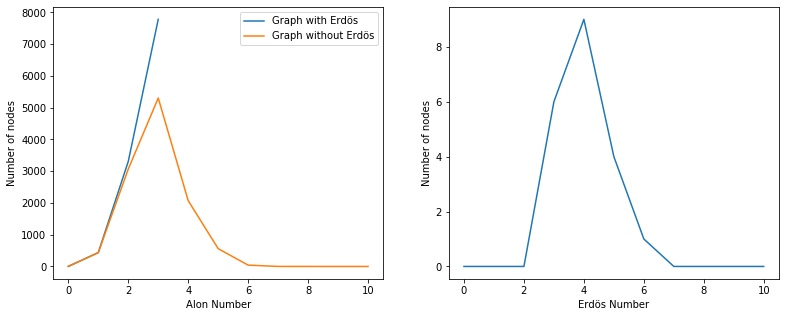

In [27]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.plot(Alon_nb, label = 'Graph with Erdös')
plt.plot(Alon_nb2, label = 'Graph without Erdös')
plt.xlabel('Alon Number')
plt.ylabel('Number of nodes')
plt.legend()

plt.subplot(122)
plt.plot(Erdos_distribution)
plt.xlabel('Erdös Number')
plt.ylabel('Number of nodes')
plt.show()

In [28]:
Std_Erdos = st.stdev(Erdos_nb)
Std_Alon = st.stdev(List_Alon_nb)

M_Erdos = st.mean(Erdos_nb)
M_Alon = st.mean(List_Alon_nb)

print('Standard deviation for the Erdös number distribution: ', Std_Erdos)
print('Standard deviation for the Alon number distribution: ', Std_Alon)

print('Mean of the Erdös number distribution: ', M_Erdos)
print('Mean of the Alon number distribution: ', M_Alon)

Standard deviation for the Erdös number distribution:  0.8583950752789521
Standard deviation for the Alon number distribution:  0.908631493135608
Mean of the Erdös number distribution:  4
Mean of the Alon number distribution:  2.9457317073170732


The Erdos number and the Alon number distributions look quite alike: they have a similar shape and almost the same standard deviation (0.86 and 0.91). The means are also different: 4 for the Erdös number, 3 for the Alon number. The problem is that the two distributions are not really relevant to compare: the Erdös number is computed for scientists in the whole collaboration graph while the Alon number is computed for the authors at a maximum distance of 2 from Erdös. It is not very surprising that the mean is lower for the Alon number: we only look at people close to Alon.

One last thing we can check is the Alon number of the researchers fro the geometry team. That way, we are sure to be able to compare the two distribution since they both come from the same dataset. We use here again the *MathSciNet* distance calculator.

In [29]:
data_geometry2 = {'Name': ['Aurélien Alvarez', 'Claude Danthony', 'Mikael De la Salle', 'Damien Gaboriau', 'Etienne Ghys', 'Alexey Glutsyuk', 'Adrien Le Boudec', 'Amine Marrakchi', 'Marco Mazzucchelli', 'Bruno Sevennec', 'Jean-Claude Sikorav', 'Alexei Tsugvintsev', 'Abdelghani Zeghib', 'Laurent Bartholdi', 'Dominik Francoeur', 'Auguste Hebert', 'Paul-Henry Leemann', 'Valentine Roos', 'Mario Shannon', 'Simon Allais', 'Matthieu Joseph', 'Kambiz Moghaddamfar'], 'Function': ['Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Permanent member', 'Visiting professor', 'Postdoc', 'Postdoc', 'Postdoc', 'Postdoc', 'Postdoc', 'Ph.D. Student', 'Ph.D. Student', 'Ph.D. Student'], 'Erdös Number': [3,3,3,3,4,4,4,5,4,3,5,4,4,3,5,6,4,'inf',5,'inf',4,4], 'Alon number':[3,3,3,3,3,3,3,5,4,3,4,4,4,3,5,6,3,'inf',5,'inf',4,4]}
geometry_panda2 = pd.DataFrame(data_geometry2)
pd.options.display.max_colwidth = 500
geometry_panda2

,Name,Function,Erdös Number,Alon number
0,Aurélien Alvarez,Permanent member,3,3
1,Claude Danthony,Permanent member,3,3
2,Mikael De la Salle,Permanent member,3,3
3,Damien Gaboriau,Permanent member,3,3
4,Etienne Ghys,Permanent member,4,3
5,Alexey Glutsyuk,Permanent member,4,3
6,Adrien Le Boudec,Permanent member,4,3
7,Amine Marrakchi,Permanent member,5,5
8,Marco Mazzucchelli,Permanent member,4,4
9,Bruno Sevennec,Permanent member,3,3


In [30]:
Alon_nb_geometry = [3,3,3,3,3,3,3,5,4,3,4,4,4,3,5,6,3,5,4,4]

Std_Alon_geo = st.stdev(Alon_nb_geometry)
M_Alon_geo = st.mean(Alon_nb_geometry)

print('Standard deviation for the Erdös number distribution: ', Std_Erdos)
print('Standard deviation for the Alon number distribution: ', Std_Alon_geo)

print('Mean of the Erdös number distribution: ', M_Erdos)
print('Mean of the Alon number distribution: ', M_Alon_geo)

Standard deviation for the Erdös number distribution:  0.8583950752789521
Standard deviation for the Alon number distribution:  0.910465468000326
Mean of the Erdös number distribution:  4
Mean of the Alon number distribution:  3.75


The result is surprinsing: first, when we used the distance calculator it appeared that the paths between the authors of the geometry team and Alon almost never go through Erdös. Second, those paths are the same length as those between the geometry team Erdös or smaller. 

Indeed, the mean Alon number is of 3.75 while the mean Erdös number is of 4. Could it be that Alon is actually closer to the other researchers than Erdös? In our graph Erdös' betweenness and closeness are higher than Alon's ones, but maybe this is different in the whole collaboration graph. Of course, it could also be that we look at a too small part of the collaboration graph and that what we can see on the geometry team of the ENS of Lyon is not representative of the whole collaboration graph. Indeed the difference on the means comes from the fact that two researchers, Etienne Ghys and Jean-Claude Sikorav, have an Alon number one point higher than their Erdös number. All the others have identical Erdös and Alon numbers, this is probably not enough for us to build a reliable mean.

### Conclusion

From this study we learnt severa things. Erdös still hold the record of the researcher with the most collaborators, even though Noga Alon is close. The Erdös graph is a small world network with small distances (diameter of 4) and a high clustering. Indeed, if we take Erdös' node off the graph stays mainly connected. The few centrality measures we looked at change a little the relative importance of each node, but it is clear that in this graph the most important nodes are those with the highest degrees, which correspond to authors with the most colaborators. It is possible to build relevant communities based on the authors locations since researchers usually collaborate more with people in the same country as them. Finally, we can define an Alon number which seems to have properties similar to Erdös'. 

With more time, it could be interesting to build smaller communities and study their relevance. Wth more computational power, it would also be relevant to establish a cluster tree of our graph and to see how it agrees with our centrality measures and our community partition.

### References

[1] https://oakland.edu/enp/, The Erdös Number Project

[2] https://en.wikipedia.org/

[3] https://www.researchgate.net/ 

[4] Anthonisse, J. M., "The rush in a directed graph", *Technical Report BN 9/71*, 1971

[5] Sabidussi, G., "The centrality index of a graph", *Psychometrika*, 1966

[6] Ulrik Brandes, "A Faster Algorithm for Betweenness Centrality", *The Journal of Mathematical Sociology*, 2001

[7] Vincent D. Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Etienne Lefebvre, "Fast unfolding of communities in large networks" *J. Stat. Mech.*, 2008 

[8] R.D. Luce and A.D. Perry, "A method of matrix analysis of group structure". *Psychometrika*, 1949

[9] Vladimir Batagelj and Andrej Mrvar, "Some analyses of Erdos collaboration graph", *Social Networks*, 2000

[10] https://mathscinet.ams.org/mathscinet/freeTools.html?version=2, distance calculator